In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
import itertools
import warnings

# 忽略警告
warnings.filterwarnings('ignore')

# 设置绘图风格
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)


ModuleNotFoundError: No module named 'skopt'

In [2]:
rename_dict = {
    '温度，oC': '温度',
    '频率，Hz': '频率',
    '磁芯损耗，w/m3': '磁芯损耗',
    '励磁波形': '励磁波形',
    '磁芯材料': '磁芯材料'
}

In [3]:
train_data=pd.read_csv('data_C3.csv')

In [4]:
train_data.rename(columns=rename_dict, inplace=True)

print("训练集数据总览：")
print(train_data.head())

训练集数据总览：
   温度     频率         磁芯损耗 励磁波形  0（磁通密度B，T）         1         2         3  \
0  25  50030  1997.955250  正弦波    0.000213  0.000389  0.000566  0.000743   
1  25  50020  2427.749830  正弦波   -0.000551 -0.000358 -0.000165  0.000028   
2  25  50020  3332.725760  正弦波   -0.003780 -0.003564 -0.003349 -0.003134   
3  25  50020  4502.908007  正弦波   -0.000511 -0.000267 -0.000023  0.000222   
4  25  50030  6063.023248  正弦波    0.000458  0.000732  0.001007  0.001281   

          4         5  ...      1015      1016      1017      1018      1019  \
0  0.000919  0.001096  ... -0.001374 -0.001198 -0.001022 -0.000846 -0.000669   
1  0.000221  0.000413  ... -0.002284 -0.002091 -0.001899 -0.001707 -0.001515   
2 -0.002919 -0.002704  ... -0.005713 -0.005499 -0.005285 -0.005070 -0.004855   
3  0.000466  0.000711  ... -0.002707 -0.002463 -0.002220 -0.001976 -0.001732   
4  0.001555  0.001830  ... -0.002016 -0.001741 -0.001466 -0.001192 -0.000917   

       1020      1021      1022      1023  磁芯材料  
0 -

In [5]:
# 删除全为NaN的列（假设为最后一列）
train_data = train_data.dropna(axis=1, how='all')

# 检查缺失值
print("\n缺失值统计：")
print(train_data.isnull().sum())

train_data['励磁波形'] = train_data['励磁波形'].astype(str)
train_data['磁芯材料'] = train_data['磁芯材料'].astype(str)

# 提取磁通密度数据（假设磁通密度采样点从第6列开始）
flux_columns = train_data.columns[4:-1]  # 前4列是温度、频率、损耗、波形，最后一列是材料

# 计算磁通密度峰值（Bm），这里使用flux_max
train_data['flux_max'] = train_data[flux_columns].max(axis=1)

# 计算传输磁能 f * Bm
train_data['transmission_energy'] = train_data['频率'] * train_data['flux_max']

print("\n提取后的数据预览：")
print(train_data[['温度', '频率', '磁芯损耗', '励磁波形', '磁芯材料', 'flux_max', 'transmission_energy']].head())



缺失值统计：
温度            0
频率            0
磁芯损耗          0
励磁波形          0
0（磁通密度B，T）    0
             ..
1020          0
1021          0
1022          0
1023          0
磁芯材料          0
Length: 1029, dtype: int64

提取后的数据预览：
   温度     频率         磁芯损耗 励磁波形 磁芯材料  flux_max  transmission_energy
0  25  50030  1997.955250  正弦波  材料1  0.028849          1443.296709
1  25  50020  2427.749830  正弦波  材料1  0.031419          1571.587184
2  25  50020  3332.725760  正弦波  材料1  0.035535          1777.447095
3  25  50020  4502.908007  正弦波  材料1  0.040015          2001.571458
4  25  50030  6063.023248  正弦波  材料1  0.045028          2252.732329


In [6]:
flux_columns = train_data.columns[4:-3]
train_data = train_data.drop(columns=flux_columns)

In [7]:
train_data

,温度,频率,磁芯损耗,励磁波形,磁芯材料,flux_max,transmission_energy
0,25,50030,1997.955250,正弦波,材料1,0.028849,1443.296709
1,25,50020,2427.749830,正弦波,材料1,0.031419,1571.587184
2,25,50020,3332.725760,正弦波,材料1,0.035535,1777.447095
3,25,50020,4502.908007,正弦波,材料1,0.040015,2001.571458
4,25,50030,6063.023248,正弦波,材料1,0.045028,2252.732329
...,...,...,...,...,...,...,...
12395,90,199190,20604.900210,梯形波,材料4,0.034867,6945.182230
12396,90,199190,26504.284280,梯形波,材料4,0.038341,7637.188209
12397,90,199190,46232.491530,梯形波,材料4,0.048877,9735.819988
12398,90,199190,61458.085900,梯形波,材料4,0.054889,10933.350467


In [8]:
# 定义分类和数值特征
categorical_features = ['励磁波形', '磁芯材料']
numeric_features = ['温度', '频率', 'flux_max', 'transmission_energy']

# 创建ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ])

# 分离特征与目标变量
X = train_data.drop(['磁芯损耗'], axis=1)
y = train_data['磁芯损耗']


In [9]:
X

,温度,频率,励磁波形,磁芯材料,flux_max,transmission_energy
0,25,50030,正弦波,材料1,0.028849,1443.296709
1,25,50020,正弦波,材料1,0.031419,1571.587184
2,25,50020,正弦波,材料1,0.035535,1777.447095
3,25,50020,正弦波,材料1,0.040015,2001.571458
4,25,50030,正弦波,材料1,0.045028,2252.732329
...,...,...,...,...,...,...
12395,90,199190,梯形波,材料4,0.034867,6945.182230
12396,90,199190,梯形波,材料4,0.038341,7637.188209
12397,90,199190,梯形波,材料4,0.048877,9735.819988
12398,90,199190,梯形波,材料4,0.054889,10933.350467


In [10]:
# 定义回归模型（随机森林回归）
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# 拟合模型
model_rf.fit(X, y)

# 预测
y_pred_rf = model_rf.predict(X)

# 评估模型
r2_rf = r2_score(y, y_pred_rf)
mae_rf = mean_absolute_error(y, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y, y_pred_rf))
accuracy = np.mean(np.abs((y_pred_rf - y) / y) < 0.10) * 100

print("\n随机森林回归模型评估指标：")
print(f"R-squared: {r2_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"Accuracy (±10%): {accuracy:.2f}%")


随机森林回归模型评估指标：
R-squared: 0.9978
MAE: 7232.2984
RMSE: 17602.8748
Accuracy (±10%): 87.41%


In [11]:
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

# 定义参数空间
space  = [
    Integer(25, 90, name='温度'),
    Categorical(['正弦波', '三角波', '梯形波'], name='励磁波形'),
    Categorical(['材料1', '材料2', '材料3', '材料4'], name='磁芯材料'),
    Real(50000, 500000, name='频率'),
    Real(train_data['flux_max'].min(), train_data['flux_max'].max(), name='flux_max')
]

alpha = 1.0  # 磁芯损耗的权重
beta = 1.0   # 传输磁能的权重
@use_named_args(space)
def objective(**params):
    single_point = pd.DataFrame([params])
    # 传输磁能 f * Bm
    single_point['transmission_energy'] = single_point['频率'] * single_point['flux_max']
    # 确保分类变量为字符串类型
    single_point['励磁波形'] = single_point['励磁波形'].astype(str)
    single_point['磁芯材料'] = single_point['磁芯材料'].astype(str)
    # 确保数值特征为浮点数
    single_point['温度'] = single_point['温度'].astype(float)
    #print("单一数据点:\n", single_point)
    # 保证列顺序一致
    single_point = single_point[X.columns]
    # 预测磁芯损耗
    try:
        predicted_core_loss = model_rf.predict(single_point)[0]
    except Exception as e:
        print(f"预测时出错: {e}")
        raise e
    # 计算复合目标
    composite_obj = alpha * predicted_core_loss - beta * single_point['transmission_energy'].values[0]
    return composite_obj
# 执行贝叶斯优化
res_gp = gp_minimize(
    objective,                  # 目标函数
    dimensions=space,           # 参数空间
    acq_func="EI",              # 采集函数
    n_calls=50,                 # 评估次数
    random_state=42             # 随机种子
)
# 获取最优参数
optimal_params = {
    '温度': res_gp.x[0],
    '励磁波形': res_gp.x[1],
    '磁芯材料': res_gp.x[2],
    '频率': res_gp.x[3],
    'flux_max': res_gp.x[4]
}



In [12]:
# 计算传输磁能
optimal_params['transmission_energy'] = optimal_params['频率'] * optimal_params['flux_max']

# 创建单一数据点的DataFrame
best_point = pd.DataFrame([optimal_params])

# 确保分类变量为字符串类型
best_point['励磁波形'] = best_point['励磁波形'].astype(str)
best_point['磁芯材料'] = best_point['磁芯材料'].astype(str)

# 确保数值特征为浮点数
best_point['温度'] = best_point['温度'].astype(float)

# 调试用
print("最优数据点:\n", best_point)




最优数据点:
      温度 励磁波形 磁芯材料            频率  flux_max  transmission_energy
0  90.0  正弦波  材料1  121987.02596  0.017438           2127.25361


In [13]:
new_order = ['温度', '频率', '励磁波形', '磁芯材料', 'flux_max', 'transmission_energy']
# 重新排列列
best_point = best_point[new_order]
best_point

,温度,频率,励磁波形,磁芯材料,flux_max,transmission_energy
0,90.0,121987.02596,正弦波,材料1,0.017438,2127.25361


In [14]:
# 预测磁芯损耗
best_core_loss = model_rf.predict(best_point)[0]

# 计算复合目标
best_transmission_energy = optimal_params['transmission_energy']
composite_obj = alpha * best_core_loss - beta * best_transmission_energy

# 打印最优条件
print("\n最优条件（贝叶斯优化）：")
print(f"温度: {optimal_params['温度']} °C")
print(f"励磁波形: {optimal_params['励磁波形']}")
print(f"磁芯材料: {optimal_params['磁芯材料']}")
print(f"频率: {optimal_params['频率']:.2f} Hz")
print(f"磁通密度峰值 (Bm): {optimal_params['flux_max']:.4f} T")
print(f"传输磁能 (f * Bm): {best_transmission_energy:.2f} Hz·T")
print(f"预测磁芯损耗: {best_core_loss:.2f} W/m³")
print(f"复合目标值: {composite_obj:.2f}")


最优条件（贝叶斯优化）：
温度: 90 °C
励磁波形: 正弦波
磁芯材料: 材料1
频率: 121987.03 Hz
磁通密度峰值 (Bm): 0.0174 T
传输磁能 (f * Bm): 2127.25 Hz·T
预测磁芯损耗: 773.25 W/m³
复合目标值: -1354.00


In [17]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei'] 

matplotlib.rcParams['axes.unicode_minus'] = False

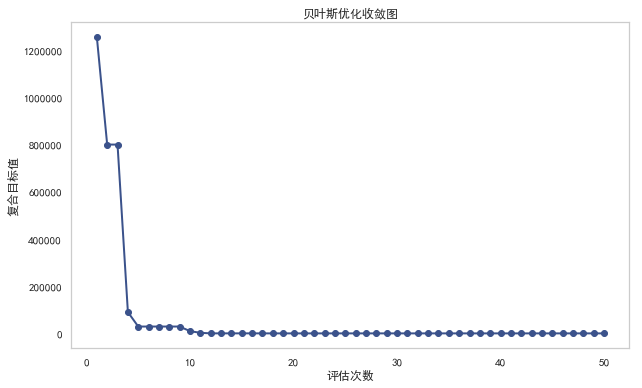

In [21]:
from skopt.plots import plot_convergence, plot_objective
# 绘制优化收敛图
plt.figure(figsize=(10, 6))
plot_convergence(res_gp)
plt.title('贝叶斯优化收敛图')
plt.xlabel('评估次数')
plt.ylabel('复合目标值')
plt.show()

<Figure size 864x2016 with 0 Axes>

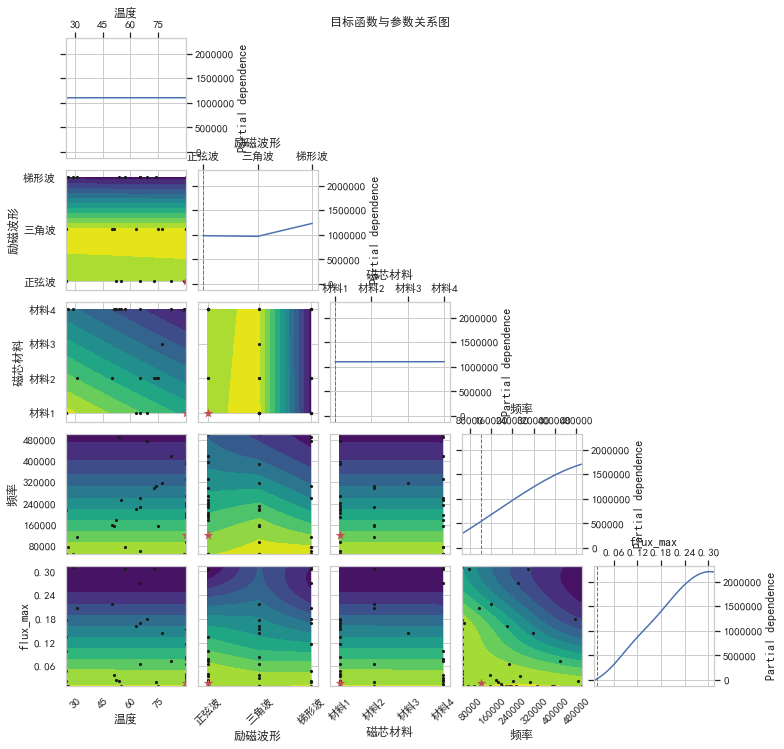

In [25]:
plt.figure(figsize=(12, 28))
plot_objective(res_gp)
plt.suptitle('目标函数与参数关系图')
plt.show()


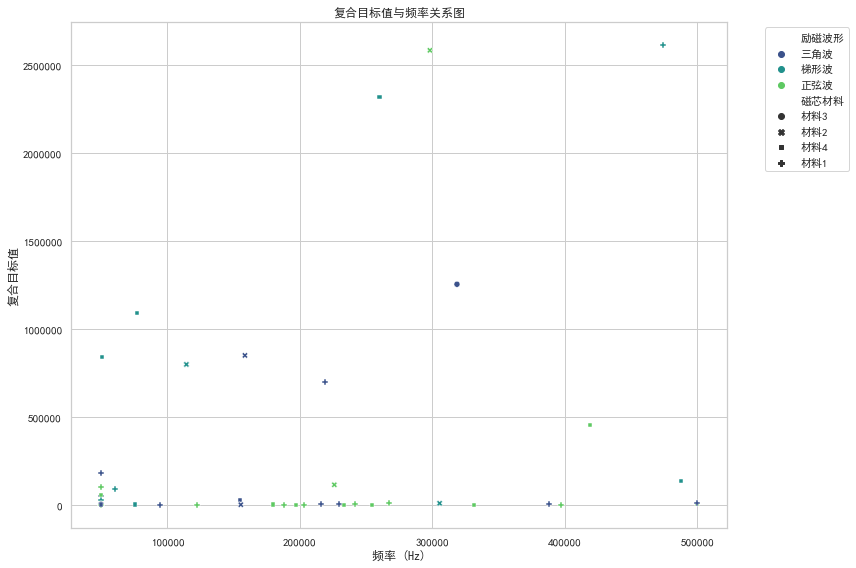

In [30]:
# 提取所有评估点和对应的目标函数值
evaluations = pd.DataFrame(res_gp.x_iters, columns=['温度', '励磁波形', '磁芯材料', '频率', 'flux_max'])
evaluations['transmission_energy'] = evaluations['频率'] * evaluations['flux_max']
evaluations['励磁波形'] = evaluations['励磁波形'].astype(str)
evaluations['磁芯材料'] = evaluations['磁芯材料'].astype(str)
# 计算预测磁芯损耗
evaluations['predicted_core_loss'] = model_rf.predict(evaluations[X.columns])

# 计算复合目标值
evaluations['composite_obj'] = alpha * evaluations['predicted_core_loss'] - beta * evaluations['transmission_energy']

# 绘制复合目标值随参数变化的散点图
plt.figure(figsize=(12, 8))
sns.scatterplot(data=evaluations, x='频率', y='composite_obj', hue='励磁波形', style='磁芯材料', palette='viridis')
plt.title('复合目标值与频率关系图')
plt.xlabel('频率 (Hz)')
plt.ylabel('复合目标值')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

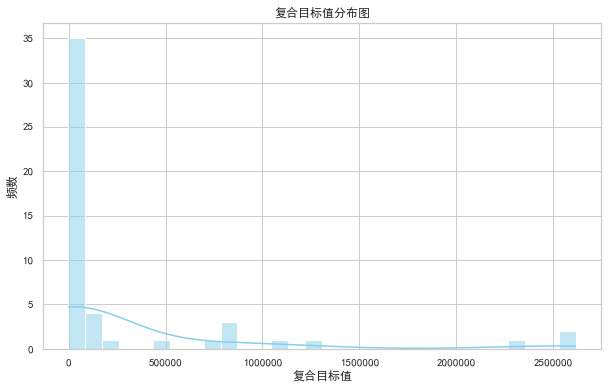

In [31]:
# 绘制复合目标值的分布图
plt.figure(figsize=(10, 6))
sns.histplot(evaluations['composite_obj'], bins=30, kde=True, color='skyblue')
plt.title('复合目标值分布图')
plt.xlabel('复合目标值')
plt.ylabel('频数')
plt.show()

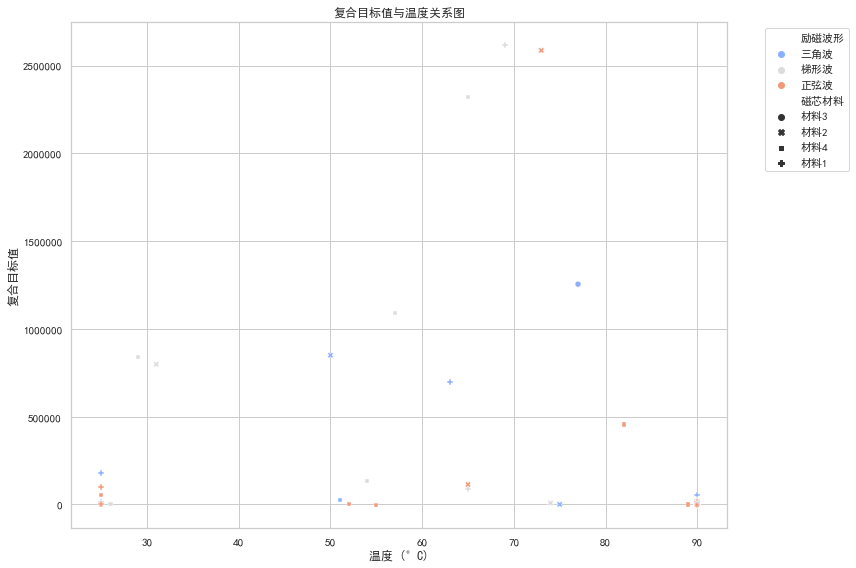

In [38]:
# 绘制复合目标值与温度的关系图
plt.figure(figsize=(12, 8))
sns.scatterplot(data=evaluations, x='温度', y='composite_obj', hue='励磁波形', style='磁芯材料', palette='coolwarm')
plt.title('复合目标值与温度关系图')
plt.xlabel('温度 (°C)')
plt.ylabel('复合目标值')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

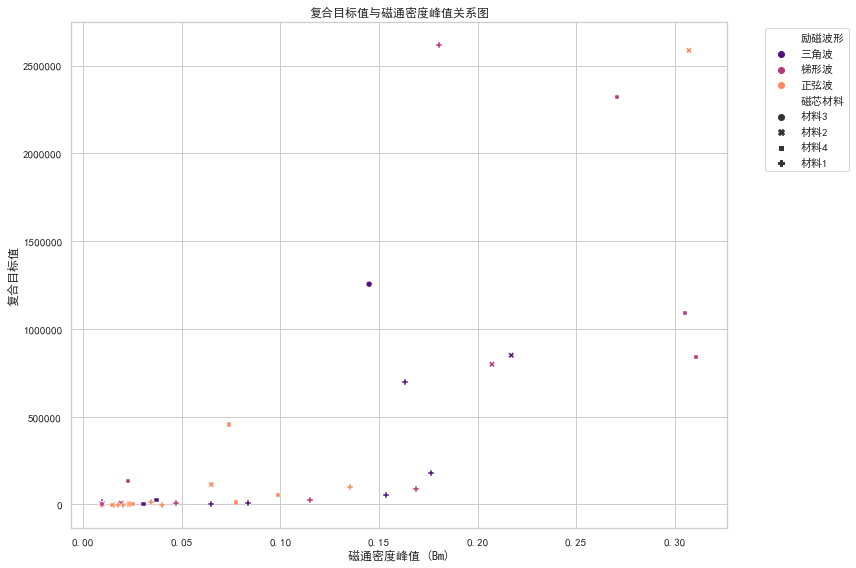

In [39]:
# 绘制复合目标值与磁通密度峰值的关系图
plt.figure(figsize=(12, 8))
sns.scatterplot(data=evaluations, x='flux_max', y='composite_obj', hue='励磁波形', style='磁芯材料', palette='magma')
plt.title('复合目标值与磁通密度峰值关系图')
plt.xlabel('磁通密度峰值 (Bm)')
plt.ylabel('复合目标值')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

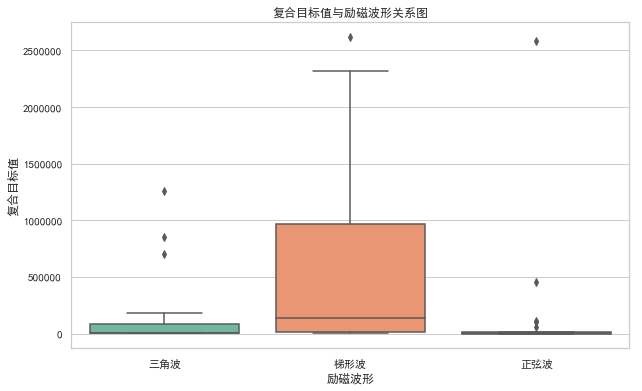

In [34]:
# 绘制复合目标值与励磁波形的关系图
plt.figure(figsize=(10, 6))
sns.boxplot(data=evaluations, x='励磁波形', y='composite_obj', palette='Set2')
plt.title('复合目标值与励磁波形关系图')
plt.xlabel('励磁波形')
plt.ylabel('复合目标值')
plt.show()

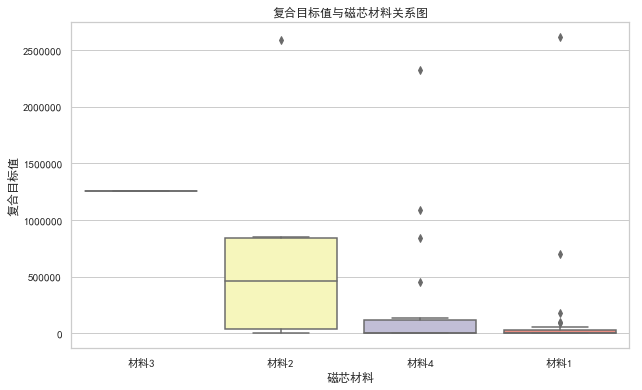

In [35]:
# 绘制复合目标值与磁芯材料的关系图
plt.figure(figsize=(10, 6))
sns.boxplot(data=evaluations, x='磁芯材料', y='composite_obj', palette='Set3')
plt.title('复合目标值与磁芯材料关系图')
plt.xlabel('磁芯材料')
plt.ylabel('复合目标值')
plt.show()

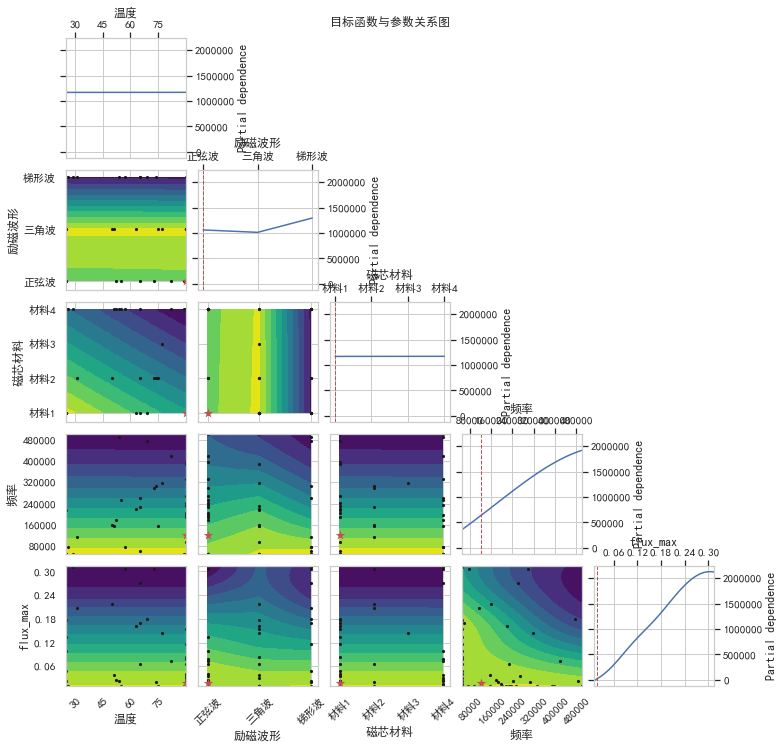

In [40]:
plot_objective(res_gp)
plt.suptitle('目标函数与参数关系图')
plt.show()


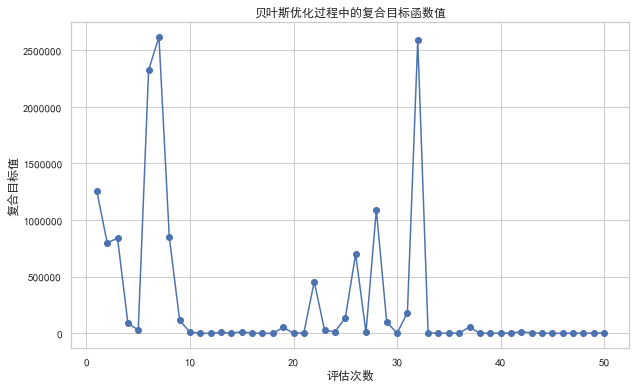

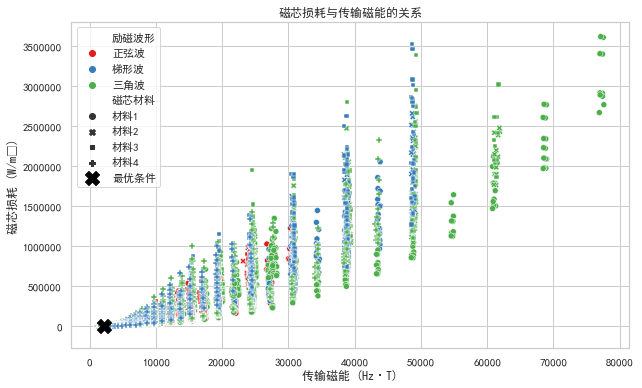

In [16]:
# 可视化优化过程中的目标函数变化
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(res_gp.func_vals) + 1), res_gp.func_vals, marker='o')
plt.title('贝叶斯优化过程中的复合目标函数值')
plt.xlabel('评估次数')
plt.ylabel('复合目标值')
plt.grid(True)
plt.show()

# 可视化最优条件与数据分布
plt.figure(figsize=(10, 6))
sns.scatterplot(x='transmission_energy', y='磁芯损耗', hue='励磁波形', style='磁芯材料', data=train_data, palette='Set1')
plt.scatter(best_transmission_energy, best_core_loss, color='black', s=200, label='最优条件', marker='X')
plt.title('磁芯损耗与传输磁能的关系')
plt.xlabel('传输磁能 (Hz·T)')
plt.ylabel('磁芯损耗 (W/m³)')
plt.legend()
plt.show()
